<a id='summary'></a>
# EGT Lyon : complete population sample
* Creation of a table with 1 row per travel, with relevant socio-economic and transport information about the corresponding person and their corresponding household. 
* Omitting trips (elemental components of a travel corresponding to a single transport mode) because they do dot pertain to the motive of the travel and the transport mode is already described in the travel table. 
* Trips could be considered eventually to find meaningful multimodal travels (especially bus + train if we separate bus and train as distinct modes)

## Comparison with other pop samples from state of the art

* Education level : Joubert2020, Ma2018
* Sun met l'ethnie (!)
* Fournier met le rôle dans le foyer (child, spouse...)
* Revenu : Sun, Zhang2019, Fournier2021
* Ma2018 adds variable on the nature of the workplace : 1 not-fixed, 2 working at home 3 fixed out-of-home working place

## Summary
* [Loading data](#loading)


* [Mode & motive mapping](#mapping)
    * [motive](#motive)
    * [mode](#mode)
    
    
* [Adding columns](#adding)
    * [merging occupation and socio-pro category](#profession)
    * [commute informations](#commute)
    
    
* [Merging](#merging)


* [Cleaning & renaming](#cleaning)
    * [age binning](#age)
    * [Descriptive stats](#descr)
    
    
* [Export](#export)


* [Dictionnary of resulting dataset](#dictionnary)



In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely import wkt
import json
import os

from utils.chrono import Chrono


with open('config.json', 'r') as config_path:
    config = json.load(config_path)

<a id='loading'></a>
# Loading data

## GIS
* EGT for lyon uses Zones Fines, something that looks like IRIS
* Some Zone Fines are **points**. We report each point to the non-point zone that contains it.
* [back to summary](#summary)

In [2]:
xmin, ymin, xmax, ymax = 3910400, 2516300, 3936000, 2541900
study_zone_wkt = "POLYGON(({0} {1}, {0} {3}, {2} {3}, {2} {1}, {0} {1}))".format(xmin,ymin,xmax,ymax)
study_zone = wkt.loads(study_zone_wkt)

c = Chrono('Loading GIS...')
zf_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_gis_filename'])
zf_ori = gpd.read_file(zf_path).to_crs('epsg:3035')
zf_ori['ZF2015_Nouveau_codage'] = zf_ori['ZF2015_Nouveau_codage'].astype(int)
zf_ori['is_point'] = zf_ori.geometry.to_wkt().str.startswith('POINT')

c.write('Intersecting with study zone...')
zf = zf_ori.drop(zf_ori[~zf_ori['geometry'].intersects(study_zone)].index)
# buffering because weird poly make intersection crash  # NOT buffering points.
zf.loc[~zf['is_point'], 'geometry'] = zf[~zf['is_point']]['geometry'].buffer(1).intersection(study_zone)


c.write('Reporting points zf to their containing polygon zf...')
zf_points = zf[zf['is_point']]
zf = zf.drop(zf.index[zf['is_point']])
zf_points['x'] = zf_points['geometry'].x
zf_points['y'] = zf_points['geometry'].y
zf_points = zf_points.drop(zf_points[~zf_points['geometry'].within(study_zone)].index)

zf_points['cart'] = 1
zf['cart'] = 1
cart = zf_points.merge(zf[['ZF2015_Nouveau_codage', 'geometry', 'cart']], on='cart', suffixes=('','_poly'))
cart = cart.drop(cart[~cart['geometry'].within(cart['geometry_poly'])].index)
zf_replace_dict = {idzfpoint: idzf for idzfpoint, idzf in cart[['ZF2015_Nouveau_codage',
                                                                'ZF2015_Nouveau_codage_poly']].values}

c.write('{} zones fines'.format(len(zf)))
c.done()



17:32:23	Loading GIS...
00:00:01	Intersecting with study zone...
00:00:01	Reporting points zf to their containing polygon zf...
00:00:01	591 zones fines
00:00:01	Work complete !


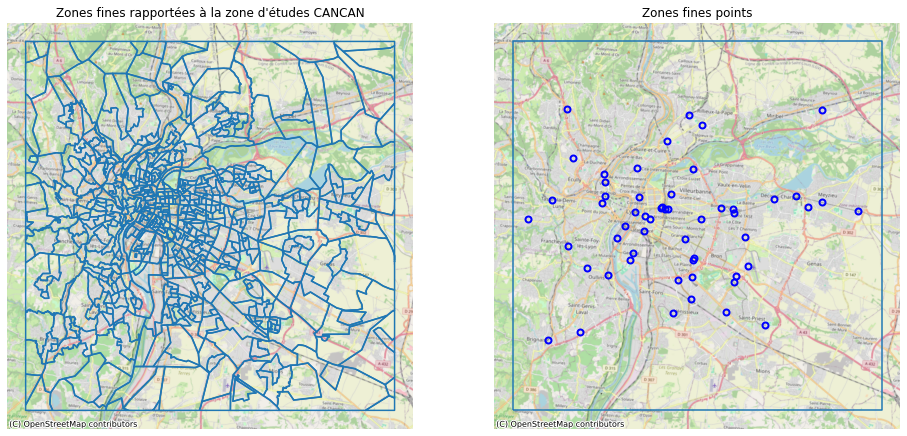

In [3]:

import contextily as ctx
import matplotlib.pyplot as plt

size = 8
fig,axes=plt.subplots(1,2,figsize=(2*size,size))

ax = axes[0]
zf.boundary.plot(ax=ax)
ax.axis(False)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='epsg:3035')
ax.set_title('Zones fines rapportées à la zone d\'études CANCAN')

ax = axes[1]
gpd.GeoSeries(study_zone).boundary.plot(ax=ax)
ax.scatter(zf_points['x'], zf_points['y'], color=(0,0,0,0), edgecolors='b', linewidth=2)
ax.axis(False)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='epsg:3035')
ax.set_title('Zones fines points')

plt.show()

In [4]:
zf['wkt'] = zf['geometry'].to_wkt()
zf_filtered_outpath = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['HTS_gis_filtered_filename'])
zf.drop(columns=['geometry']).to_csv(zf_filtered_outpath, index=False)

## EGT
* household ID is determined by the `ZF` id and `ECH` id, concatenated.
* [back to summary](#summary)

In [5]:
c = Chrono('Loading households...')
men_faf_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_men_faf_filename'])
men_faf = pd.read_csv(men_faf_path, sep=';',dtype={'ZFM':str, 'ECH':str})
men_tel_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_men_tel_filename'])
men_tel = pd.read_csv(men_tel_path, sep=';',dtype={'ZFM':str, 'ECH':str})
men = pd.concat([men_faf,men_tel])
men['id_men'] = men['ZFM'] + men['ECH']
c.write('{} rows ({} in faf - {} in tel)'.format(len(men), len(men_faf), len(men_tel)))

c.write('Loading persons...')
per_faf_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_per_faf_filename'])
per_faf = pd.read_csv(per_faf_path, sep=';', dtype={'ZFP':str, 'ECH':str,'PER':str})
per_tel_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_per_tel_filename'])
per_tel = pd.read_csv(per_tel_path, sep=';', dtype={'ZFP':str, 'ECH':str,'PER':str})
per = pd.concat([per_faf, per_tel])
per['id_men'] = per['ZFP'] + per['ECH']
per['id_per'] = per['id_men'] + per['PER']
per = per.drop(['ECH'], axis=1)
c.write('{} rows ({} in faf - {} in tel)'.format(len(per), len(per_faf), len(per_tel)))

c.write('Loading travels...')
depl_faf_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_depl_faf_filename'])
depl_faf = pd.read_csv(depl_faf_path, sep=';', dtype={'D4':str, 'D8':str, 'ZFD':str, 'ECH':str,'PER':str, 'NDEP':str})
depl_tel_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_depl_tel_filename'])
depl_tel = pd.read_csv(depl_tel_path, sep=';', dtype={'D4':str, 'D8':str, 'ZFD':str, 'ECH':str,'PER':str, 'NDEP':str})
depl = pd.concat([depl_faf,depl_tel])
depl['id_per'] = depl['ZFD'] + depl['ECH'] + depl['PER']
depl['id_dep'] = depl['id_per'] + depl['NDEP']
depl = depl.drop(['ECH', 'PER'], axis=1)
c.write('{} rows ({} in faf - {} in tel)'.format(len(depl), len(depl_faf), len(depl_tel)))


# c.write('Loading trips...')
# traj_faf = pd.read_csv('../../data/EGT_lyon/csv/Fichiers_Standard_Face_a_face/lyon_2015_std_faf_traj.csv', sep=';')
# traj_tel = pd.read_csv('../../data/EGT_lyon/csv/Fichiers_Standard_Telephone/lyon_2015_std_tel_traj.csv', sep=';')
# traj = pd.concat([traj_faf,traj_tel])
# traj['id_dep'] = traj['ZFT'].astype(str) + traj['ECH'].astype(str) + traj['PER'].astype(str) + traj['NDEP'].astype(str)
# traj['id_traj'] = traj['id_dep'] + traj['T1'].astype(str)  # T1 : n° de trajet
# c.write('{} rows ({} in faf - {} in tel)'.format(len(traj), len(traj_faf), len(traj_tel)))



c.write('Reporting point ZF...')
men['ZFM'] = men['ZFM'].replace(zf_replace_dict).astype(int)
per['ZFP'] = per['ZFP'].replace(zf_replace_dict).astype(int)
depl['ZFD'] = depl['ZFD'].replace(zf_replace_dict).astype(int)
depl['D3'] = depl['D3'].replace(zf_replace_dict).astype(int) # D3: ZF origin
depl['D7'] = depl['D7'].replace(zf_replace_dict).astype(int) # D7: ZF destination


c.write('Keeping only depl for which we have a zf inside study zone...')
depl = depl[depl['D3'].isin(zf['ZF2015_Nouveau_codage'].astype(int)) & 
     depl['D7'].isin(zf['ZF2015_Nouveau_codage'].astype(int))]
c.write('{} rows'.format(len(depl)))


c.write('Keeping only per inside study zone...')
c.write('{} rows'.format(len(per)))
per = per[per['ZFP'].isin(zf['ZF2015_Nouveau_codage'])]
c.write('{} rows'.format(len(per)))


c.write('Keeping only men inside study zone...')
c.write('{} rows'.format(len(men)))
men = men[men['ZFM'].isin(zf['ZF2015_Nouveau_codage'])]
c.write('{} rows'.format(len(men)))


c.done()

17:32:31	Loading households...
00:00:00	16361 rows (9746 in faf - 6615 in tel)
00:00:00	Loading persons...
00:00:00	36564 rows (21061 in faf - 15503 in tel)
00:00:00	Loading travels...
00:00:00	99585 rows (68153 in faf - 31432 in tel)
00:00:00	Reporting point ZF...
00:00:01	Keeping only depl for which we have a zf inside study zone...
00:00:01	55591 rows
00:00:01	Keeping only per inside study zone...
00:00:01	36564 rows
00:00:01	18572 rows
00:00:01	Keeping only men inside study zone...
00:00:01	16361 rows
00:00:01	8692 rows
00:00:01	Work complete !


### Sanity check: field `PENQ` indicate people who have given an agenda, but this agenda may be actually empty

In [6]:
got_agenda = depl.groupby('id_per').size().rename('got_agenda').reset_index()
per_got_agenda = per.merge(got_agenda, on='id_per', how='left')

per_got_agenda['got_agenda'] = per_got_agenda['got_agenda']>0
per_got_agenda['PENQ'] = per_got_agenda['PENQ']>0

pd.crosstab(per_got_agenda['PENQ'], 
            per_got_agenda['got_agenda'])

got_agenda,False,True
PENQ,,
False,1631,0
True,2637,14304


In [7]:
(per['P14']==1).mean()

0.019976308421279346

<a id='mapping'></a>
# Mode and motive mapping

<a id='motive'></a>
##  Mapping of motive
Details taken from EGT Lyon dictionnary. 
### Simplified mapping :
* **0** : Home
* **1** : Work
* **2** : Study
* **3** : Shopping
* **4** : Personal

### Joubert2020 modalitites (comparison)
> _we combined primary and secondary (e1) with tertiary education (e2) into simply education (e). Secondly, recreational visits to friends (v) were recoded as leisure (l) activities. Thirdly, activities with a medical purpose (m) were combined with other activities (o)._
* home
* work
* education
* dropping/picking up kids at school 
* shopping
* leisure
* other


* [back to summary](#summary)

In [8]:
motive_mapping = {1 : 0,# Domicile (partir de, se rendre à)
                  2 : 0,# Résidence secondaire, logement occasionnel, hôtel, autre domicile (partir de, se rendre à)
                  11 : 1,# Travailler sur le lieu d’emploi déclaré
                  12 : 1,# Travailler sur un autre lieu – télétravail
                  13 : 1,# Travailler sur un autre lieu hors télétravail
                  14 : 1,# Travailler sur un autre lieu sans distinction
                  21 : 2,# Être gardé (nourrice, crèche...)
                  22 : 2,# Étudier sur le lieu d'études déclaré (école maternelle et primaire)
                  23 : 2,# Étudier sur le lieu d'études déclaré (collège)
                  24 : 2,# Étudier sur le lieu d'études déclaré (lycée)
                  96 : 2,# Étudier sur le lieu d'études déclaré (collège ou lycée). Cas egt personne accompagnée
                  25 : 2,# Étudier sur le lieu d'études déclaré (universités et grandes écoles)
                  26 : 2,# Étudier sur un autre lieu (école maternelle et primaire)
                  27 : 2,# Étudier sur un autre lieu (collège)
                  28 : 2,# Étudier sur un autre lieu (lycée)
                  97 : 2,# Étudier sur un autre lieu (collège ou lycée). Cas egt personne accompagnée
                  29 : 2,# Étudier sur un autre lieu (universités et grandes écoles)
                  30 : 3,# Visite d’un magasin, d’un centre commercial ou d’un marché de plein vent sans effectuer d’achat
                  31 : 3,# Réaliser plusieurs motifs en centre commercial
                  32 : 3,# Faire des achats en grand magasin, supermarché, hypermarché et leurs galeries marchandes
                  33 : 3,# Faire des achats en petit et moyen commerce
                  34 : 3,# Faire des achats en marché couvert et de plein vent
                  35 : 3,# Faire des achats dans un magasin "drive"
                  98 : 3,# Faire des achats sans précision (egt, motif personne accompagnée)
                  41 : 4,# Recevoir des soins (santé)
                  42 : 4,# Faire une démarche autre que rechercher un emploi
                  43 : 2,# Rechercher un emploi
                  51 : 4,# Participer à des loisirs, des activités sportives, culturelles ou associatives
                  52 : 4,# Faire une promenade, du « lèche-vitrines », prendre une leçon de conduite
                  53 : 4,# Se restaurer hors du domicile
                  54 : 4,# Visiter des parents ou des amis
                  61 : 4,# Accompagner quelqu’un (personne présente)
                  62 : 4,# Aller chercher quelqu’un (personne présente)
                  63 : 4,# Accompagner quelqu’un (personne absente)
                  64 : 4,# Aller chercher quelqu’un (personne absente)
                  71 : 4,# Déposer une personne à un mode de transport (personne présente)
                  72 : 4,# Reprendre une personne à un mode de transport (personne présente)
                  73 : 4,# Déposer d’une personne à un mode de transport (personne absente)
                  74 : 4,# Reprendre une personne à un mode de transport( personne absente)
                  81 : 1,# Réaliser une tournée professionnelle
                  82 : 3,# Tournée de magasin sans achat
                  91 : 3}# Autres motifs (préciser)
print(len(motive_mapping))

42


In [9]:
motive_mapping2 = {1 : 0,# Domicile (partir de, se rendre à)
                  2 : 0,# Résidence secondaire, logement occasionnel, hôtel, autre domicile (partir de, se rendre à)
                  11 : 1,# Travailler sur le lieu d’emploi déclaré
                  12 : 1,# Travailler sur un autre lieu – télétravail
                  13 : 1,# Travailler sur un autre lieu hors télétravail
                  14 : 1,# Travailler sur un autre lieu sans distinction
                  21 : 2,# Être gardé (nourrice, crèche...)
                  22 : 2,# Étudier sur le lieu d'études déclaré (école maternelle et primaire)
                  23 : 2,# Étudier sur le lieu d'études déclaré (collège)
                  24 : 2,# Étudier sur le lieu d'études déclaré (lycée)
                  96 : 2,# Étudier sur le lieu d'études déclaré (collège ou lycée). Cas egt personne accompagnée
                  25 : 2,# Étudier sur le lieu d'études déclaré (universités et grandes écoles)
                  26 : 2,# Étudier sur un autre lieu (école maternelle et primaire)
                  27 : 2,# Étudier sur un autre lieu (collège)
                  28 : 2,# Étudier sur un autre lieu (lycée)
                  97 : 2,# Étudier sur un autre lieu (collège ou lycée). Cas egt personne accompagnée
                  29 : 2,# Étudier sur un autre lieu (universités et grandes écoles)
                  30 : 3,# Visite d’un magasin, d’un centre commercial ou d’un marché de plein vent sans effectuer d’achat
                  31 : 3,# Réaliser plusieurs motifs en centre commercial
                  32 : 3,# Faire des achats en grand magasin, supermarché, hypermarché et leurs galeries marchandes
                  33 : 3,# Faire des achats en petit et moyen commerce
                  34 : 3,# Faire des achats en marché couvert et de plein vent
                  35 : 3,# Faire des achats dans un magasin "drive"
                  98 : 3,# Faire des achats sans précision (egt, motif personne accompagnée)
                  41 : 4,# Recevoir des soins (santé)
                  42 : 4,# Faire une démarche autre que rechercher un emploi
                  43 : 2,# Rechercher un emploi
                  51 : 5,# Participer à des loisirs, des activités sportives, culturelles ou associatives
                  52 : 5,# Faire une promenade, du « lèche-vitrines », prendre une leçon de conduite
                  53 : 5,# Se restaurer hors du domicile
                  54 : 5,# Visiter des parents ou des amis
                  61 : 4,# Accompagner quelqu’un (personne présente)
                  62 : 4,# Aller chercher quelqu’un (personne présente)
                  63 : 4,# Accompagner quelqu’un (personne absente)
                  64 : 4,# Aller chercher quelqu’un (personne absente)
                  71 : 4,# Déposer une personne à un mode de transport (personne présente)
                  72 : 4,# Reprendre une personne à un mode de transport (personne présente)
                  73 : 4,# Déposer d’une personne à un mode de transport (personne absente)
                  74 : 4,# Reprendre une personne à un mode de transport( personne absente)
                  81 : 1,# Réaliser une tournée professionnelle
                  82 : 3,# Tournée de magasin sans achat
                  91 : 3}# Autres motifs (préciser)
depl['destination_motive2'] = depl['D5A'].replace(motive_mapping2)
depl.groupby('destination_motive2').size()/len(depl)

destination_motive2
0    0.391466
1    0.139915
2    0.091508
3    0.124822
4    0.122340
5    0.129949
dtype: float64

In [17]:
print([k for k in motive_mapping.keys() if motive_mapping[k]!= motive_mapping2[k]])

[51, 52, 53, 54]


In [7]:
depl['origin_motive'] = depl['D2A'].replace(motive_mapping)
depl['destination_motive'] = depl['D5A'].replace(motive_mapping)

In [9]:
depl.groupby(['origin_motive', 'destination_motive']).size()

origin_motive  destination_motive
0              0                       55
               1                     4852
               2                     4430
               3                     3647
               4                     8728
1              0                     4323
               1                      856
               2                        9
               3                      794
               4                     1674
2              0                     3944
               1                       11
               2                      211
               3                      213
               4                      730
3              0                     4683
               1                      388
               2                       58
               3                     1013
               4                      762
4              0                     8641
               1                     1487
               2                      377


In [26]:
purpose_purpose_vols = (depl
 .merge(per[['id_per', 'COE1']], on='id_per')
 .groupby(['origin_motive', 'destination_motive'])['COE1'].sum())
purpose_purpose_vols = (purpose_purpose_vols/purpose_purpose_vols.sum()).reset_index()

purpose_purpose_vols[((purpose_purpose_vols['origin_motive']==0) & (purpose_purpose_vols['destination_motive']==1)) | 
                     ((purpose_purpose_vols['origin_motive']==0) & (purpose_purpose_vols['destination_motive']==2)) | 
                     ((purpose_purpose_vols['origin_motive']==1) & (purpose_purpose_vols['destination_motive']==0)) | 
                     ((purpose_purpose_vols['origin_motive']==2) & (purpose_purpose_vols['destination_motive']==0))
                    ]['COE1'].sum() / purpose_purpose_vols['COE1'].sum()

0.33304327338712836

In [8]:
# Deleting delivery persons
livreur_id = depl.loc[depl['D5A']==81,'id_per'].unique()

print(len(depl['id_per'].unique()), 'persons')
depl = depl.drop(depl[depl['id_per'].isin(livreur_id)].index)
print(len(depl['id_per'].unique()), 'persons after filtering')


15086 persons
15006 persons after filtering


<a id='mode'></a>
### Mapping of modes
* Details taken from EGT Lyon dictionnary. 
* /!\ if modifying the simplified mapping, take care of correspondance in other parts of the notebook (transport_mode_commute) where this mapping is used as is !
#### Simplified mapping :
* **0** : Walking
* **1** : Bicycle
* **2** : Private motorized
* **3** : Public transport
* **other** (Boat, plane, tractor, quad) : we just drop them

#### Joubert 2020 modalities (comparison)
* none
* private car
* public transport w walk
* other

* [back to summary](#summary)

In [9]:
mode_mapping = {
 1: 0, # Marche à pied
10: 1, # Conducteur VLS
11: 1, # Conducteur de vélo
12: 1, # Passager de vélo
13: 2, # Conducteur de deux ou trois roues motorisés < 50 cm3
14: 2, # Passager de deux ou trois roues motorisés < 50 cm3
15: 2, # Conducteur de deux ou trois roues motorisés >= 50 cm3
16: 2, # Passager de deux ou trois roues motorisés >= 50 cm3
17: 2, # Conducteur de deux ou trois roues motorisés (si pas de détail sur la cylindrée)
18: 2, # Passager de deux ou trois roues motorisés (si pas de détail sur la cylindrée)
21: 2, # Conducteur de véhicule particulier (VP)
22: 2, # Passager de véhicule particulier (VP)
31: 3, # Passager de bus urbain (réseau ville centre)
32: 3, # Passager de tramway (réseau ville centre)
33: 3, # Passager de métro (réseau ville centre)
37: 3, # Transport à la demande (U ou IU)
38: 3, # Passager d'autres réseaux urbains dans l'aire d'enquête
39: 3, # Passager d'autres réseaux urbains hors aire d'enquête
41: 3, # Passager de transports collectifs départementaux
42: 3, # Passager d'autres autocars (dont lignes régionales, TER routiers, périscolaire, occasionnel, lignes internationales en cabotage)
51: 3, # Passager de trains
61: 2, # Passager de taxi
71: 3, # Transport d'employeur (exclusivement)
81: 2, # Conducteur de fourgon, camionnette, camion (pour tournées professionnelles ou déplacements privés)
82: 2, # Passager de fourgon, camionnette, camion (pour tournées professionnelles ou déplacements privés)
91: -1, # Transport fluvial ou maritime
92: -1, # Avion
93: 1, # Roller, skate, trottinette
94: 0, # Fauteuil roulant
95: -1, # Autres modes (tracteur, engin agricole, quad, etc.)
}

In [10]:
depl['MODP'] = depl['MODP'].replace(mode_mapping)

* Suppressing persons who have at least one trip with "other" transport mode.

In [11]:
print(len(depl['id_per'].unique()), 'persons')
other_mode_id = depl.loc[depl['MODP']==-1,'id_per'].unique()
depl = depl.drop(depl[depl['id_per'].isin(other_mode_id)].index)
print(len(depl['id_per'].unique()), 'persons after filtering')


15006 persons
14988 persons after filtering


<a id='adding'></a>
# Adding columns
* [back to summary](#summary)

## Deriving `home status` from the column `M2`

|val|men['M2']|home_status|
|---|---|---|
|**0**  |Owner| Owner |
|**1**  |HLM tenant | HLM tenant  |
|**2**  |Other tenant | Tenant
|**3**  |Logé gratuitement|  (mapped to owner)
|**4**  |résidence universitaire |  (mapped to tenant)
|**5**  |Autre Exclusif |  (mapped to tenant) 
|**6**  |Autre Non précisé |  (mapped to HLM tenant)
|**Missing**  | |  (mapped to tenant)

* 40% of values are missing in `men['M2']`, this is pretty bad.


In [12]:
print('{:.2f}% of missing values for men[\'M2\']'.format(100*men['M2'].isna().mean()))
men['M2'] = men['M2'].fillna(7)

6.24% of missing values for men['M2']


<AxesSubplot:>

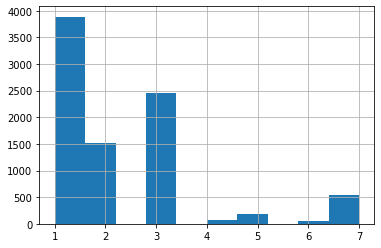

In [13]:
men['M2'].hist()

In [14]:
men['home_status'] = men['M2'].replace({1:0, 2:1, 3:2, 4:0, 5:2, 6:1, 7:2})

## Actual hour of travel
* Column of hour travel is written as a HHMM str.
* Travels after 24h are considered as taking place the day after.

In [15]:
depl['hour'] = depl['D4'].str[:2].astype(int)
depl['hour'] = depl['hour']%24

## Household has a car
* **Joubert2020 modalities:** `None (4 264)`; `Single (2 541)`; `Multiple (2 443)`
* **Sun2015 modalities:** `Yes` ; `No`

In [16]:
men['has_car'] = (men['M6']>0).replace({False:0, True:1})

## Nb of person in the household
* **Yameogo2021 modalities:** `1 person` ; `2+`

In [17]:
col = per.groupby('id_men').size().reset_index().rename(columns={0:'nb_per_in_household'})
men = men.merge(col, on='id_men')

## Work from home
* **0** : person does not work from home
* **1** : person works from home


In [18]:
per['work_from_home'] = per['P14'].astype('Int64')
per['work_from_home'] = per['work_from_home'].fillna(2).replace({2:0})

## Gender 
* **0**: male
* **1**: female

In [19]:
per['gender'] = per['P2'].replace({1:0, 2:1})

<a id='age'></a>
## Binning age
* Other modalities in the state of the art :
    * **Sun2015**  : 15–19; 20–24; 25–29; 30–34; 35–39; 40–44; 45–49; 50–54; 55–59; 60–64; 65–69; 70/ +
    * **Ma2018** : <30 years old, 30-40, 40-50, 50-60, >60
    * **Joubert2020**  : Infant (20); Child (690); Young (1591); Early career (3 633); Late career (2 283); Unknown (473)
    * **Hor2020** : <15    15-29    30-44    45-59    60-74    75+
    * **Fournier2021**  : 0-9 10-14 15-19 20-24 (25-44?) 45-54 55-64 >65
    * **Yameogo2021** : 0-2; 3-5; 6-10; 11-14; 15-17; 18-24; 25-29; 30-39; 40-54; 55-64; 65-79; 80/+

In [20]:
from utils.binage import bin_age
per['age'] = bin_age(per['P4'])

<a id='profession'></a>
## Occupation & socio-pro category
|val|P9|PCSC|occupation|
|---|---|---|---|
|**0**  | | Non réponse | inactif, chômeur
|**1**  |Travail à plein temps |  Agriculteurs exploitants | Agriculteurs exploitants
|**2**  |Travail à temps partiel |  Artisans, commerçants et chefs d'entreprise | Artisans, commerçants et chefs d'entreprise
|**3**  |alternance, stage |  Cadres| Cadres
|**4**  |Étudiant |  Professions Intermédiaires | Professions Intermédiaires
|**5**  |Scolaire jusqu'au bac |  Employés | Employés
|**6**  |Chômeur, recherche un emploi |  Ouvriers | Ouvriers
|**7**  |Retraité |  Élèves, étudiants | Élèves, étudiants
|**8**  |Reste au foyer |  Chômeurs n'ayant jamais travaillé | Retraité
|**9**  |Autre |  Autres inactifs n'ayant jamais travaillé | 

* P9==8 and P9==9 ('Reste au foyer' and 'Autre') are confusing : people are still working
* See the visualization notebook for the confusion matrix between P9 and PCSC

#### Horl2020 modalitites (comparison)
* Agriculture 
* Independent 
* Science 
* Intermediate 
* Employee 
* Worker 
* Retired 
* Other

In [21]:
def occupation_pcsc_merge(occupation, pcsc):
    res = np.nan
    if (occupation in [6]) or (pcsc in [8, 9]):
        return 0  # inactive of some sort.
    elif occupation==7:
        return 8
    elif pcsc in [1,2,3,4,5,6,7]:
        return pcsc
    return res

per['occupation'] = per[['P9', 'PCSC']].apply(lambda r: occupation_pcsc_merge(r['P9'], r['PCSC']), axis=1)

print('{} missing values for occupation'.format(per['occupation'].isna().sum())) 

1092 missing values for occupation


> only 2 of those missing values have either a P9 or a PCSC :

In [22]:
per[(per['occupation'].isna()) & ((~per['P9'].isna()) | (~per['PCSC'].isna()))][['P9','PCSC']]

,P9,PCSC
387,1.0,0.0
388,1.0,0.0


<a id='merging'></a>
# Merging

In [23]:
menper = men.merge(per, on='id_men', how='left')
menperdep = menper.merge(depl, on='id_per', how='left')
# menperdeptraj = menperdep.merge(traj.drop(['ECH', 'PER', 'NDEP'], axis=1), on='id_dep', how='left')

## Sanity checks
### Checking that we don't loose too many households, persons or travel rows when joining

In [24]:
menper_inner = men.merge(per, on='id_men', how='inner')
menperdep_inner = menper.merge(depl, on='id_per', how='inner')

print('{} households (original)'.format(len(men)))
print('{} households (menper)'.format(len(menper_inner.groupby('id_men'))))
print('{} households (menperdep)'.format(len(menperdep_inner.groupby('id_men'))))
print('________________________________')
print('{} persons (original)'.format(len(per)))
print('{} persons (menper)'.format(len(menper_inner.groupby('id_per'))))
print('{} persons (menperdep)'.format(len(menperdep_inner.groupby('id_per'))))
print('________________________________')
print('{} travels (original)'.format(len(depl)))
print('{} travels (menperdep)'.format(len(menperdep_inner.groupby('id_dep'))))


8692 households (original)
8692 households (menper)
7841 households (menperdep)
________________________________
18572 persons (original)
18572 persons (menper)
14219 persons (menperdep)
________________________________
55112 travels (original)
53477 travels (menperdep)


### Checking that "travels to the declared place of work/study" end in the same place as the declared place

In [25]:
print('Before processing of the motive:')
travels_to_work = menperdep[menperdep['D5A'].isin([11,22,23,24,25])][['D7', 'P15']]
print('{:.1f}% of travels to the declared place of work end up in the declared place of work P15 of the person'.format(
        100*(travels_to_work['D7'] == travels_to_work['P15']).mean()))

Before processing of the motive:
98.2% of travels to the declared place of work end up in the declared place of work P15 of the person


In [26]:
print('After processing of the motive:')
travels_to_work = menperdep[menperdep['destination_motive'].isin([1,2])][['D7', 'P15']]
print('{:.1f}% of travels to the place of work end up in the declared place of work P15 of the person'.format(
        100*(travels_to_work['D7'] == travels_to_work['P15']).mean()))

After processing of the motive:
84.8% of travels to the place of work end up in the declared place of work P15 of the person


<a id='cleaning'></a>
# Cleaning and renaming
* [back to summary](#summary)

In [27]:
renaming_dict = {
    'id_men' : 'id_men',
    'id_per' : 'id_per',
    'ZFM':'zf_home',
    'IDP4':'commune',
    'home_status':'home_status',
    'has_car':'has_car',
    'nb_per_in_household':'nb_per_in_household',
    'gender':'gender',
    'age':'age',
    'P7':'has_license',
    'P14':'work_from_home',
    'P15':'zf_work',
    'occupation':'occupation',
    'COE0' : 'scaling_factor_household',
    'COE1' : 'scaling_factor_person',
    'PENQ':'PENQ',
}

pop_sample = menperdep[list(renaming_dict.keys())].rename(columns=renaming_dict)

pop_sample['occupation'] = pop_sample['occupation'].astype('Int64')
#pop_sample['zf_work'] = pop_sample['zf_work'].astype('Int64')

# 1 is yes, 2 is no --"
pop_sample['has_license'] = pop_sample['has_license'].fillna(2).replace({2:0})

pop_sample = pop_sample.groupby(['id_men', 'id_per']).first().reset_index()
pop_sample

,id_men,id_per,zf_home,commune,home_status,has_car,nb_per_in_household,gender,age,has_license,work_from_home,zf_work,occupation,scaling_factor_household,scaling_factor_person,PENQ
0,00101001115,001010011151,101001,69123,2.0,1,2,0,1,1.0,2.0,252004.0,6,43.10767,54.14797,1.0
1,00101001115,001010011152,101001,69123,2.0,1,2,1,1,1.0,2.0,119651.0,7,43.10767,54.14797,1.0
2,0010100184,00101001841,101001,69123,1.0,0,4,0,3,1.0,NaN,NaN,0,48.91878,29.75996,1.0
3,0010100184,00101001842,101001,69123,1.0,0,4,1,2,0.0,2.0,104001.0,5,48.91878,51.85581,1.0
4,0010100184,00101001843,101001,69123,1.0,0,4,1,0,0.0,2.0,212003.0,7,48.91878,53.59816,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18567,00707008485,007070084851,707008,69123,2.0,1,1,1,2,1.0,2.0,144001.0,3,50.78189,41.34416,1.0
18568,00707008494,007070084941,707008,69123,2.0,1,2,0,3,1.0,NaN,NaN,8,55.90144,39.06945,NaN
18569,00707008494,007070084942,707008,69123,2.0,1,2,1,3,1.0,NaN,NaN,8,55.90144,39.06945,1.0
18570,00707008546,007070085461,707008,69123,2.0,1,2,1,3,1.0,NaN,NaN,0,55.90144,39.06945,1.0


<a id='export'></a>
# Exporting population sample
* [back to summary](#summary)

In [28]:
outpath = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['HTS_filtered_filename'])
print(outpath)
pop_sample.to_csv(outpath, index=False)
pop_sample.head()

/Users/benoit/Desktop/Pro/210526-fusion/outdata/egt_lyon_pop_sample/egt_lyon_pop_sample.csv


,id_men,id_per,zf_home,commune,home_status,has_car,nb_per_in_household,gender,age,has_license,work_from_home,zf_work,occupation,scaling_factor_household,scaling_factor_person,PENQ
0,00101001115,001010011151,101001,69123,2.0,1,2,0,1,1.0,2.0,252004.0,6,43.10767,54.14797,1.0
1,00101001115,001010011152,101001,69123,2.0,1,2,1,1,1.0,2.0,119651.0,7,43.10767,54.14797,1.0
2,0010100184,00101001841,101001,69123,1.0,0,4,0,3,1.0,NaN,NaN,0,48.91878,29.75996,1.0
3,0010100184,00101001842,101001,69123,1.0,0,4,1,2,0.0,2.0,104001.0,5,48.91878,51.85581,1.0
4,0010100184,00101001843,101001,69123,1.0,0,4,1,0,0.0,2.0,212003.0,7,48.91878,53.59816,1.0


### Also exporting depl so we can create activity chains in another notebook

In [29]:
outpath = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['HTS_depl_filtered_filename'])
print(outpath)
depl.to_csv(outpath, index=False)
depl.head()

/Users/benoit/Desktop/Pro/210526-fusion/outdata/egt_lyon_pop_sample/depl.csv


,DP1,IDD3,IDD4,ZFD,NDEP,GD1,STD,D2A,D2B,D3,...,D10,D11,D12,MODP,TYPD,id_per,id_dep,origin_motive,destination_motive,hour
0,3,2015,69123,101001,1,69123,101,1,NaN,101001,...,1,1110,1665,3,1,00101001841,001010018411,0,4,10
1,3,2015,69123,101001,2,69123,101,42,NaN,102001,...,1,1110,1665,3,1,00101001841,001010018412,4,0,11
2,3,2015,69123,101001,1,69123,101,1,NaN,101001,...,1,2590,3885,3,1,00101001842,001010018421,0,1,8
3,3,2015,69123,101001,2,69123,101,11,NaN,104001,...,2,2750,4125,3,1,00101001842,001010018422,1,0,17
4,3,2015,69123,101001,1,69123,101,1,NaN,101001,...,1,2390,3585,3,1,00101001843,001010018431,0,2,7


<a id='dictionnary'></a>
# Final sample dictionnary
* **id_men** : household id
* **id_per** : person id
* **id_dep** : travel id
* **zf_home** : home zf id (591 modalities for lyon)
* **zf_work** : work zf id (591 modalities for lyon)
* **has_car** : (0:no 1:yes)
* **nb_per_in_household** : (1 to 10)
* **has_license** : (0:no 1:yes)
* **work_from_home** : (0:no 1:yes)
* **scaling_factor_household** : 
* **scaling_factor_person** : 

|modality| gender | age   | occupation                                  | transport_mode    | motive   |
|--------|--------|-------|---------------------------------------------|-------------------|----------|
|**0**   | male   | 0-17  | inactif, chômeur                            | Walking           | Home     |
|**1**   | female | 18-29 | Agriculteurs exploitants                    | Bicycle           | Work     |
|**2**   |        | 30-59 | Artisans, commerçants et chefs d'entreprise | Private motorized | Study    |
|**3**   |        | 60+    | Cadres                                      | Public transport  | Shopping |
|**4**   |        |       | Professions Intermédiaires                  |                   | Personal |
|**5**   |        |       | Employés                                    |                   |          |
|**6**   |        |       | Ouvriers                                    |                   |          |
|**7**   |        |       | Élèves, étudiants                           |                   |          |
|**8**   |        |       | Retraité                                    |                   |          |



* [back to summary](#summary)